In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from imagenet10 import ImageNet10, ImageNet10_test
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
import torch.nn.functional as F
import pandas as pd
import os
from config import *


# Gathers the meta data for the images
paths, classes = [], []
for i, dir_ in enumerate(CLASS_LABELS):
    for entry in os.scandir(ROOT_DIR + dir_):
        if (entry.is_file()):
            paths.append(entry.path)
            classes.append(i)
            
data = {
    'path': paths,
    'class': classes
}


data_df = pd.DataFrame(data, columns=['path', 'class'])
data_df = data_df.sample(frac=1).reset_index(drop=True) # Shuffles the data

# See what the dataframe now contains
#print("Found", len(data_df), "images.")
# If you want to see the image meta data
#print(data_df.head())

# Split the data into train and test sets and instantiate our new ImageNet10 objects.
train_split = 0.80 # Defines the ratio of train/valid data.

# valid_size = 1.0 - train_size
train_size = int(len(data_df)*train_split)

data_transform = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
        # new
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.ColorJitter(hue=0.2, saturation=0.2, brightness=0.2)
    
    
    ])

dataset_train = ImageNet10(
    df=data_df[:train_size],
    transform=data_transform,
)

dataset_valid = ImageNet10(
    df=data_df[train_size:].reset_index(drop=True),
    transform=data_transform,
)

train_loader = torch.utils.data.DataLoader(
    dataset_train,
    batch_size=64,  # The number of samples in a batch
    shuffle=True,
    num_workers=0 
)

valid_loader = torch.utils.data.DataLoader(
    dataset_valid,
    batch_size=64,
    shuffle=True,
    num_workers=0
)

# See what you've loaded
#print("len(dataset_train)", len(dataset_train))
#print("len(dataset_valid)", len(dataset_valid))

#print("len(train_loader)", len(train_loader))
#print("len(valid_loader)", len(valid_loader))



In [3]:
# load test set
paths_test = []
for entry in os.scandir(ROOT_DIR_TEST):
    if (entry.is_file()):
        paths_test.append(entry.path)
        
data_test = {'path':paths_test}
data_df_test = pd.DataFrame(data_test, columns = ['path'])
#data_df_test = data_df_test.sample(frac=1).reset_index(drop=True)

data_transform_test = transforms.Compose([
        transforms.Resize(128),
        transforms.CenterCrop(128),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD),
])

dataset_test = ImageNet10_test(
    df = data_df_test,
    transform = data_transform_test)

test_loader = torch.utils.data.DataLoader(
    dataset_test,
    batch_size = 20,
    shuffle = False,
    num_workers = 0
)


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
#Another way
class MyNewNetwork(nn.Module):
    def __init__(self, num_classes):
        super(MyNewNetwork, self).__init__()
        
        self.conv1 = nn.Sequential(nn.Conv2d(3,16, kernel_size=3, padding=1),nn.BatchNorm2d(16),
                    nn.ReLU(), nn.Dropout(), nn.MaxPool2d(kernel_size=2, stride=2)) # (128,128) -> (64,64)
        
        self.conv2 = nn.Sequential(nn.Conv2d(16,32, kernel_size=3, padding=1), nn.BatchNorm2d(32),
                    nn.ReLU(), nn.Dropout(), nn.MaxPool2d(kernel_size=2, stride=2)) # (64,64) -> (32,32)
        
        self.conv3 = nn.Sequential(nn.Conv2d(32,64, kernel_size=3, padding=1),nn.BatchNorm2d(64),
                    nn.ReLU(), nn.Dropout(), nn.MaxPool2d(kernel_size=2, stride=2)) # (32,32) -> (16,16)
        
        self.conv4 = nn.Sequential(nn.Conv2d(64, 128, kernel_size = 3, padding = 1), nn.BatchNorm2d(128),
                    nn.ReLU(), nn.Dropout(), nn.MaxPool2d(kernel_size = 2, stride = 2)) # (16,16) -> (8,8)
        
        self.classifier = nn.Sequential(nn.Linear(128*8*8, 256), nn.Dropout(), nn.BatchNorm1d(256), nn.ReLU(), 
                                        nn.Linear(256, 128), nn.Dropout(0.2), nn.BatchNorm1d(128),nn.ReLU(),
                                        nn.Linear(128, 64), nn.Dropout(), nn.BatchNorm1d(64), nn.ReLU(),
                        nn.Linear(64, num_classes))
        
    def forward(self, input):
        input = self.conv1(input)
        input = self.conv2(input)
        input = self.conv3(input)
        input = self.conv4(input)
        input = input.reshape(input.size(0), -1) 
        input = self.classifier(input)

        return input
    
    
def stats(loader, net):
    confusion_matrix = np.zeros((10,10))
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss
            n += 1
            
            # confusion matrix
            for i in range(labels.size(0)):
                label = labels.data[i]
                confusion_matrix[label][predicted.data[i]] += 1
            
    return running_loss/n, correct/total, confusion_matrix


def train(nepochs, model, train_loader, test_loader, loss_fn, optimizer):
    statsrec = np.zeros((3,nepochs))
    train_cm = np.zeros((10,10))
    
    #model.train()
    for epoch in range(nepochs):  # loop over the dataset multiple times

        running_loss = 0.0
        n = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
                        
            # Zero the parameter gradients
            optimizer.zero_grad()

            outputs = model(inputs.to(device)) # forward pass
            loss = loss_fn(outputs, labels.to(device)) # loss function
            loss.backward() # backward
            optimizer.step() #update params

            running_loss += loss.item()
            n += 1
            
            #confusion matrix
        index, train_predict = torch.max(outputs.data, 1)
        for i in range(labels.size(0)):
            label = labels.data[i]
            train_cm[label][train_predict.data[i]] += 1

        ltrn = running_loss/n
        #model.eval()
        ltst, atst, valid_cm = stats(test_loader, model)
        statsrec[:,epoch] = (ltrn, ltst, atst)
        print(f"epoch: {epoch} training loss: {ltrn: .3f}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
    
    return statsrec, model, train_cm, valid_cm


def train1(nepochs, model, train_loader, test_loader, loss_fn, optimizer):
    statsrec = np.zeros((3,nepochs))

            
    it = iter(train_loader)
    inputs, labels = next(it)
    
    for epoch in range(nepochs):  # loop over the dataset multiple times

        running_loss = 0.0
                        
            # Zero the parameter gradients
        optimizer.zero_grad()

        outputs = model(inputs.to(device)) # forward pass
        loss = loss_fn(outputs, labels.to(device)) # loss function
        loss.backward() # backward
        optimizer.step() #update params

        running_loss += loss.item()
        
        

        ltst, atst, cm = stats(test_loader, model)
        statsrec[:,epoch] = (running_loss, ltst, atst)
        print(f"epoch: {epoch} training loss: {running_loss: .3f}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")
    
    return statsrec, model, cm


# predict test data label
def predict(model, loader, data_df_test):
    prediction = [] 
    for data in loader:
        images = data
        outputs = model(images.to(device))
        _, predicted = torch.max(outputs.data, 1)
        prediction.append(predicted.tolist())
    
    prediction = sum(prediction, [])
    
    pic_name = []
    for path in data_df_test['path']:
        pic = path[20:]
        pic_name.append(pic)
        
    data_predict = {'pic_name': pic_name, 'label' : prediction}
    
    output = pd.DataFrame(data_predict, columns = ['pic_name', 'label'])
    
    return output



In [22]:
nepochs = 40
model = MyNewNetwork(10).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
#optimizer = optim.SGD(model.parameters(), momentum = 0.9, lr = 0.001)

In [ ]:
statistics, trainedmodel, train_cm, valid_cm = train(nepochs, model, train_loader, valid_loader, loss_fn, optimizer)

epoch: 0 training loss:  2.077  test loss:  1.942 test accuracy:  30.7%
epoch: 1 training loss:  1.843  test loss:  1.768 test accuracy:  37.9%
epoch: 2 training loss:  1.692  test loss:  1.632 test accuracy:  44.1%
epoch: 3 training loss:  1.567  test loss:  1.527 test accuracy:  47.8%
epoch: 4 training loss:  1.489  test loss:  1.504 test accuracy:  49.7%
epoch: 5 training loss:  1.419  test loss:  1.476 test accuracy:  52.8%
epoch: 6 training loss:  1.343  test loss:  1.385 test accuracy:  52.9%
epoch: 7 training loss:  1.285  test loss:  1.310 test accuracy:  57.6%
epoch: 8 training loss:  1.236  test loss:  1.341 test accuracy:  57.1%
epoch: 9 training loss:  1.194  test loss:  1.272 test accuracy:  59.4%
epoch: 10 training loss:  1.157  test loss:  1.223 test accuracy:  60.1%
epoch: 11 training loss:  1.100  test loss:  1.222 test accuracy:  61.1%
epoch: 12 training loss:  1.084  test loss:  1.193 test accuracy:  62.3%
epoch: 13 training loss:  1.053  test loss:  1.160 test accur

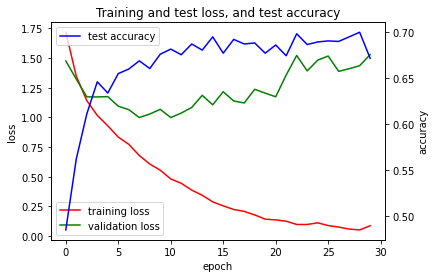

In [10]:
fig, ax1 = plt.subplots()
plt.plot(statistics[0], 'r', label = "training loss")
plt.plot(statistics[1], 'g', label = "validation loss")
plt.legend(loc = "lower left")
plt.xlabel('epoch')

plt.ylabel('loss')
plt.title('Training and test loss, and test accuracy')
ax2 = ax1.twinx()
ax2.plot(statistics[2], 'b', label = 'test accuracy')
ax2.set_ylabel('accuracy')
plt.legend(loc = "upper left")
plt.show()

Text(69.0, 0.5, 'True Labels')

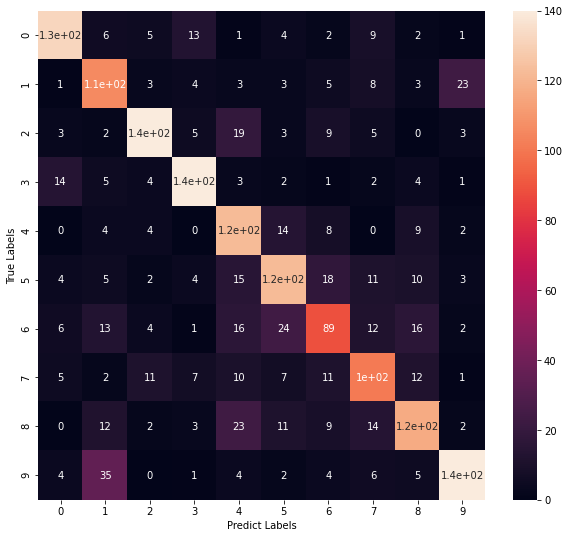

In [17]:
import seaborn as sns
plt.subplots(figsize = (10,9))
ax = sns.heatmap(valid_cm, annot = True)
ax.set_xlabel('Predict Labels')
ax.set_ylabel('True Labels')

Text(69.0, 0.5, 'True Labels')

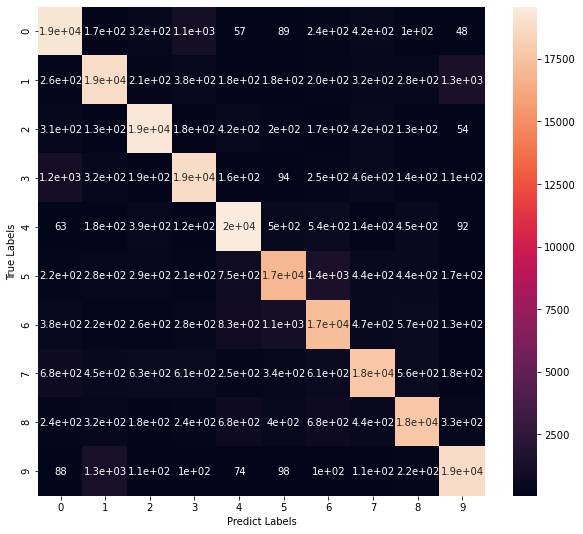

In [18]:
plt.subplots(figsize = (10,9))
ax = sns.heatmap(train_cm, annot = True)
ax.set_xlabel('Predict Labels')
ax.set_ylabel('True Labels')